#### Wichtig!
Paths müssen angepasst werden. Aus Eigeninteresse ziehe ich mir hier (meistens) die aktuellen Daten aus den jeweiligen Github repos :)

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#import pandas_datareader.data as web
import datetime
%matplotlib inline

/Users/manuelmairamtinkhof/opt/anaconda3/envs/env_conda_graphs/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Importing Files

In [2]:
# Data up to 2020-03-07
#df_confirmed = pd.read_csv(r'../data/individual/2020-03-07_confirmed.csv')
url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df_confirmed = pd.read_csv(url)
#df_deaths = pd.read_csv(r'../data/individual/2020-03-07_deaths.csv')
url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
df_deaths = pd.read_csv(url)
#df_recovered = pd.read_csv(r'../data/individual/2020-03-07_recovered.csv')
url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
df_recovered = pd.read_csv(url)

# Totals up to 2020-03-07
df_total = pd.read_csv(r'../../data/total/2020-03-07_total.csv')

## TODO: Stocks 
testings stuff... see at the end for more

Text(0.5, 1.0, 'Apple Stock since 01.01.2020')

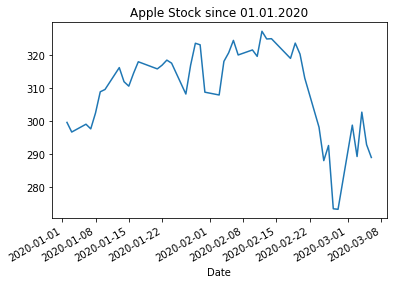

In [3]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 3, 7)

df_apple = web.DataReader("AAPL", 'yahoo', start, end)
df_apple.tail()

df_apple['Adj Close'].plot()
plt.title('Apple Stock since 01.01.2020')

## Plot Deaths

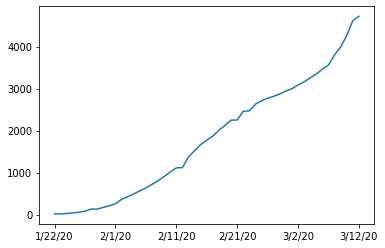

In [4]:
s_deaths = df_deaths.sum()[3:]
s_deaths.plot()

## Plot Recovered

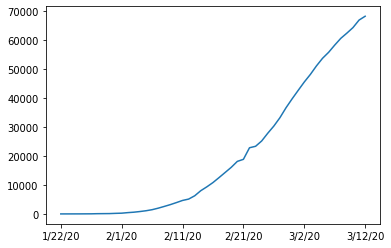

In [5]:
s_recovered = df_recovered.sum()[3:]
s_recovered.plot()

## Plot Mortality Rate of those tested
Observation: Kinda low...

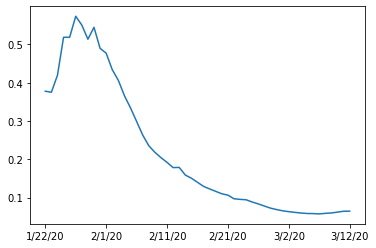

In [6]:
ratio = s_deaths / (s_deaths + s_recovered)
ratio.plot()

## Compare Development: Are we f****'d?

Data for Germany

In [106]:
ger = df_confirmed.loc[df_confirmed['Country/Region'] == 'Germany']

# Prep dataframe GER data
ger =  ger.transpose()
ger.columns = ['amount_ger']
ger['amount_ger'] = ger['amount_ger'].shift(-9)
ger = ger[30:]

Data for Italy

In [107]:
ita = df_confirmed.loc[df_confirmed['Country/Region'] == 'Italy']

# Prep dataframe ITA data
ita = ita.transpose()
ita.columns = ['amount_ita']
ita = ita[30:]

Data for US

In [108]:
us = df_confirmed.loc[df_confirmed['Country/Region'] == 'US']

# Prep dataframe US data
us = us.groupby('Country/Region').sum()
us =  us.transpose()

# Prep dataframe GER data
us.columns = ['amount_us']
us['amount_us'] = us['amount_us'].shift(-9)
us = us[30:]

Plot and Compare

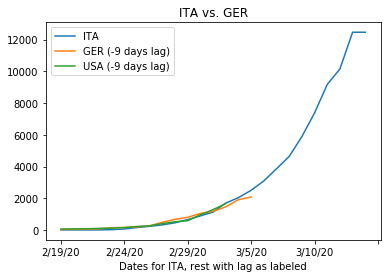

In [109]:
# Plot
ax = ita.plot(title='ITA vs. GER')
ger.plot(ax=ax)
us.plot(ax=ax)

# Set legend
ax.legend(['ITA', 'GER (-9 days lag)', 'USA (-9 days lag)'])

# Set labels
ax.set_xlabel("Dates for ITA, rest with lag as labeled")
ax.set_ylabel("Dates for ITA, rest with lag as labeled")

ax

## Map Confirmed Worldwide (todo: use right files)

In [13]:
# get country codes
url = r'https://gist.githubusercontent.com/tadast/8827699/raw/7255fdfbf292c592b75cf5f7a19c16ea59735f74/countries_codes_and_coordinates.csv'
codes = pd.read_csv(url)

# get total confirmed worldwide (todo: change file location...)
confirmed = pd.read_csv(r'countries.csv')
confirmed = confirmed[['country','confirmed']]
confirmed.columns = ['Country','confirmed']
confirmed = confirmed.groupby(['Country'], as_index=False).sum()

# Replace e.g. 'Mainland China' with 'China'
for i, row in confirmed.iterrows():
    if row['Country'] == 'Mainland China':
        confirmed.at[i,'Country'] = 'China'
    elif row['Country'] == 'US':
        confirmed.at[i,'Country'] = 'United States'
    elif row['Country'] == 'UK':
        confirmed.at[i,'Country'] = 'United Kingdom'
        
merged = confirmed.merge(codes, on="Country")

rm_quote = lambda x: x.replace('"', '')
merged['Alpha-3 code'] = merged['Alpha-3 code'].apply(rm_quote)
merged.head()

,Country,confirmed,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,12,"""AF""",AFG,"""4""","""33""","""65"""
1,Algeria,55,"""DZ""",DZA,"""12""","""28""","""3"""
2,Andorra,5,"""AD""",AND,"""20""","""42.5""","""1.6"""
3,Argentina,5,"""AR""",ARG,"""32""","""-34""","""-64"""
4,Armenia,6,"""AM""",ARM,"""51""","""40""","""45"""


In [14]:
mapped = merged[['Country', 'Alpha-3 code', 'confirmed']]

#### Trying to genearte colorcodes and indizes for coloring the map

In [15]:
col_list = list()
def generate_colors_green():
    for i in range(0, 255, 20):
        col_list.append((0+i, 255, 0+i))
        
def generate_colors_red():
    for i in range(0, 255, 20):
        col_list.append((255, 255-i, 255-i))
        
generate_colors_green()
generate_colors_red()
col_list.append((255, 0, 0))

indizes = list()
for i in range(len(col_list)):
    indizes.append(sum(indizes)+1)

In [16]:
import ipyleaflet
import json
import os
import requests
from ipywidgets import link, FloatSlider
from branca.colormap import linear, LinearColormap

# https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json
with open('geo.json', 'r') as f:  # file already in folder, no need to download from link above
    world_map1 = json.load(f)
    
confirmed = dict(zip(mapped['Alpha-3 code'].tolist(), mapped.confirmed.tolist()))
confirmed = {k.replace(' ', ''):v for k, v in confirmed.items()}

world_map2 = {'type': 'FeatureCollection', 'features': []}
for i in range(0, len(world_map1['features'])):
    if world_map1['features'][i]['id'] in confirmed.keys():
        world_map2['features'].append(world_map1['features'][i])
        
layer = ipyleaflet.Choropleth(
        geo_data=world_map2,
        choro_data=confirmed,
    colormap=LinearColormap(colors=col_list, index=indizes,vmin=0,vmax=indizes[-1]),
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

m = ipyleaflet.Map(center = (51,10), zoom = 2)
m.add_layer(layer)
m

Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

## (Not even that) simple pop up map

In [17]:
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup

In [18]:
center = (52.204793, 360.121558)

m = Map(center=center, zoom=3, close_popup_on_click=False)

def mark_locations(lat, long, nr, country):
    marker = Marker(location=(lat, 360+long))
    nr_confirmed = '# confirmed in ' + str(country) + ": " + str(nr)
    marker.popup = HTML(value=nr_confirmed)
    m.add_layer(marker)

# TODO ungeschickt gemacht
# TODO GROUP BY!!
country = df_confirmed.index
lat = df_confirmed.Lat.to_list()
long = df_confirmed.Long.to_list()
nr = df_confirmed.iloc[:,-1].to_list()

for lat, long, nr, country in zip(lat, long, nr, country):
    mark_locations(lat, long, nr, country)

m

Map(center=[52.204793, 360.121558], close_popup_on_click=False, controls=(ZoomControl(options=['position', 'zo…

## Playing with stocks

#### Clean and Explore (so you know what to plot)

In [19]:
stocks = pd.read_csv('../../data/stocks/stocks.csv')
stocks = stocks.pivot(index='symbol', columns='date', values='adjusted')
stocks = stocks.transpose()
stocks.index = pd.to_datetime(stocks.index) 
stocks.head()

symbol,GILD,LHA.DE,MRNA,NCLH,NFLX,^GDAXI,^GSPC
date,,,,,,,
2020-01-02,65.230003,16.680,19.230000,58.830002,329.809998,13385.929688,3257.850098
2020-01-03,65.070000,15.590,18.889999,57.599998,325.899994,13219.139648,3234.850098
2020-01-06,65.650002,15.340,18.129999,56.799999,335.829987,13126.990234,3246.280029
2020-01-07,65.120003,15.365,17.780001,56.970001,330.750000,13226.830078,3237.179932
2020-01-08,65.800003,15.540,17.980000,57.570000,339.260010,13320.179688,3253.050049


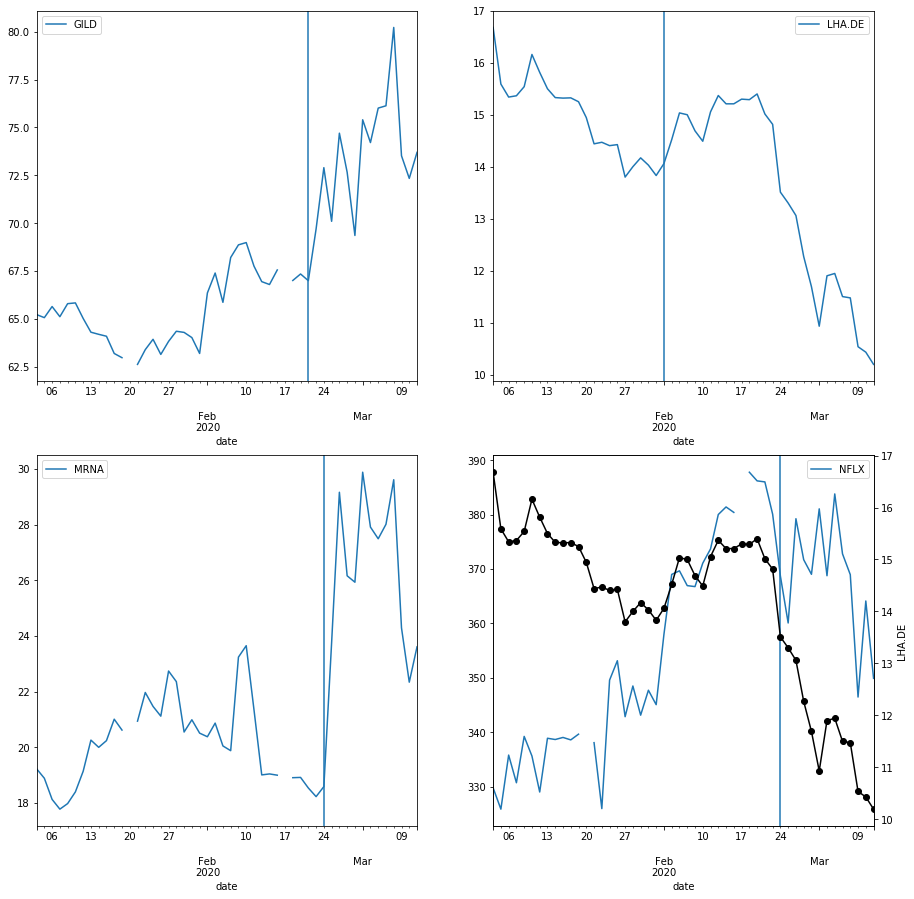

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
stocks.plot(y='GILD', ax=axs[0, 0])
stocks.plot(y='LHA.DE', ax=axs[0, 1])
stocks.plot(y='MRNA', ax=axs[1, 0])
stocks.plot(y='NFLX', ax=axs[1, 1])

axs[0, 0].axvline('2020-02-20')
axs[0, 0] = stocks['LHA.DE'].plot(secondary_y=True, color='k', marker='o')
axs[0, 0].set_ylabel('LHA.DE')

axs[0, 1].axvline('2020-02-02')
axs[1, 0].axvline('2020-02-22')
axs[1, 1].axvline('2020-02-22')

plt.show()

## Gtrends vs. Stocks

In [21]:
gtrends = pd.read_csv('../../data/gtrends/gtrends.csv')
gtrends = gtrends.set_index('date')
gtrends = gtrends[['hits']]
gtrends.columns = ['Hits']
gtrends.index = pd.to_datetime(gtrends.index)

stocks = pd.read_csv('../../data/stocks/stocks.csv')
stocks = pd.read_csv('../../data/stocks/stocks.csv')
stocks = stocks.pivot(index='symbol', columns='date', values='adjusted')
stocks = stocks.transpose()
stocks.index = pd.to_datetime(stocks.index) 

gild = stocks[['GILD']]
gild.index = pd.to_datetime(gild.index)
gild = gild.apply(lambda x: x.replace('NaN', np.nan))
         
trends_stocks = pd.concat([gtrends, gild], axis=1, sort=False)
trends_stocks = trends_stocks.interpolate()
# trends_stocks = trends_stocks.apply(lambda x: x.fillna(x.mean()),axis=0)

trends_stocks

,Hits,GILD
date,,
2020-01-01,0.0,NaN
2020-01-02,0.0,65.230003
2020-01-03,0.0,65.070000
2020-01-04,0.0,65.263334
2020-01-05,0.0,65.456668
...,...,...
2020-03-07,64.0,77.986666
2020-03-08,72.0,75.753332
2020-03-09,87.0,73.519997


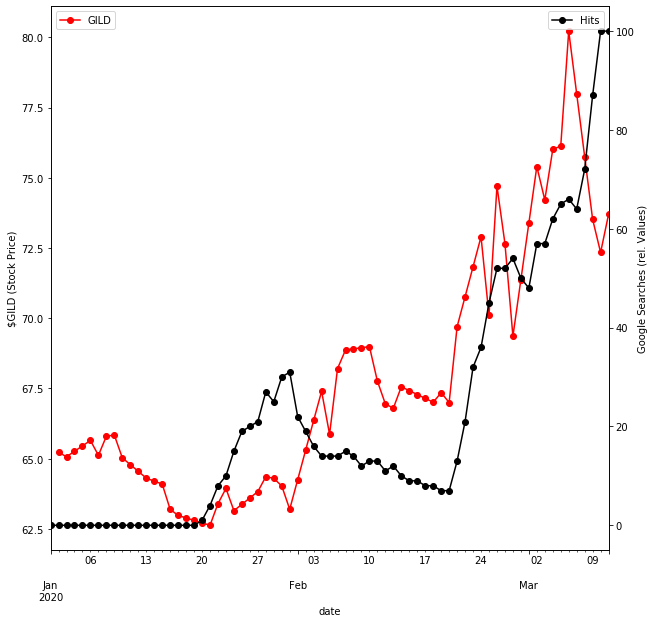

In [22]:
fig, axs = plt.subplots(figsize=(10, 10))
axs1 = trends_stocks['GILD'].plot(color='r', marker='o')
axs1.set_ylabel('$GILD (Stock Price)')
axs2 = trends_stocks['Hits'].plot(secondary_y=True, color='k', marker='o')
axs2.set_ylabel('Google Searches (rel. Values)')
axs1.legend(loc=2)
axs2.legend(loc=0)